In [1]:
import os
import geopandas
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from wavespectra import read_dataset
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator


from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

## 1. Datamesh connector

Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [2]:
datamesh = Connector(token=None)

In [3]:
TRANSFORM = ccrs.PlateCarree()  
times=  ["19850201T00", "20220101T00"]
geom = [-25.27743879956753+360,
      8.005073115713637,
      -14.039081151275498+360,
      18.18457364822658]


In [4]:
ds=datamesh.query({
  "datasource": "oceanum_wave_glob05_era5_v1_grid",
  "description": "Oceanum global ERA5 wave hindcast parameters",
  "variables": [
    "hs",
    "dpt"
  ],
  "geofilter": {
    "type": "bbox",
    "geom": geom,
  },
  "timefilter": {"type": "range", "times": times}

})

#### Functions to analyse the data

In [5]:
def nsamp(df: pd.DataFrame):
    """Number of colocations."""
    return df.dropna().shape[0]


def mad(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Mean absolute difference MAD."""
    return (df[y] - df[x]).abs().mean()


def rmsd(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Root-mean-square difference RMSD."""
    return np.sqrt(((df[y] - df[x])**2).mean())


def bias(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Bias."""
    return (df[y] - df[x]).mean()


def si(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Scatter Index."""
    return np.sqrt((((df[y] - df[x]) - bias(df, x, y))**2).mean() ) / df[x].mean()


def errors(df, x: str = "hs_obs", y: str = "hs_hds"):
    """Return a label with error summary for plotting."""
    return f"Bias: {bias(df, x, y):0.2f} m\nMAD: {mad(df, x, y):0.2f} m\nRMSD: {rmsd(df, x, y):0.2f} m\nSI: {si(df, x, y):0.2f}\nN: {nsamp(df):0.0f}"

#### Functions to plot the data

In [6]:
def plot_map(df, datasource_id, ax):
    """Plot map showing the location at the NDBC datasource."""

    # Bathy contour
    c = cali.depth.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=TRANSFORM)
    c.clabel(fmt="%0.0fm", fontsize=6)

    # Buoy location
    ax.plot(xb, yb, "o", color="#187bcd", alpha=0.3, markersize=5, transform=TRANSFORM)
    ax.plot(df.lon_obs, df.lat_obs, "o", color="#187bcd", markersize=5, alpha=0.7, transform=TRANSFORM, label="NDBC")
    ax.plot(df.lon_hds, df.lat_hds, "o", color="#d84418", markersize=5, alpha=0.7, transform=TRANSFORM, label="Hindcast")
    ax.legend(loc=1)

    # Show features
    ax.add_feature(cfeature.LAND.with_scale("10m"))
    geopandas.GeoSeries(ds_hds.geom).plot(ax=ax, facecolor="none", edgecolor="0.3", alpha=0.5, transform=TRANSFORM)

    # Axis settings
    buff = 0.1
    ax.set_extent([x0-buff, x1+buff, y0-buff, y1+buff])
    ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);
    ax.set_title(f"{datasource_id.upper().replace('_', ' ')}")

    return ax


def plot_scatter(df, ax, x="hs_obs", y="hs_hds", c="tp_obs"):
    """Plot scatter of obs and hindcast."""

    # Set xlim
    xmax = df[[x, y]].max().max() * 1.1
    xlim = ylim = [0, xmax]

    # Scatter points
    p = ax.scatter(df[x], df[y], s=5, c="#187bcd", vmin=0, vmax=20, alpha=0.5, cmap="turbo")

    # Calculate and plot quantiles
    dfq = df[[x, y]].quantile(q=np.arange(0, 1.01, 0.01))
    ax.plot(dfq[x], dfq[y], "ok")

    # Equality line
    ax.plot(xlim, ylim, "--", color="0.5")

    # Show error statistics
    ax.annotate(errors(df, x, y), xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, color="0.0", bbox=dict(facecolor="0.9"))

    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Hs NDBc (m)")
    ax.set_ylabel("Hs hindcast (m)");

    return ax


def plot_data(df, datasource_id, fac=0.7):
    """Plot map with station locations and scatter of obs and hindcast."""

    fig = plt.figure(figsize=(10*fac, 18*fac))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.0, 1.0])

    # Map
    projection = ccrs.TransverseMercator(central_longitude=float(x0 + x1)/2)
    ax = plt.subplot(gs[0], projection=projection)
    ax = plot_map(df, datasource_id, ax)

    # Scatter
    ax = plt.subplot(gs[1])
    ax = plot_scatter(df, ax, x="hs_obs", y="hs_hds", c="tp_obs")

    fig.tight_layout()
    return fig


def interpolate_model_to_altimeter(altimeter_df, model_ds):
    # Convert time columns to numeric (e.g., Unix timestamp)
    altimeter_df['time_numeric'] = altimeter_df['time'].apply(lambda x: x.timestamp())
    model_ds['time_numeric'] = pd.to_datetime(model_ds['time'].values).astype('datetime64[s]').astype(int)
    
    # Extract the model data and coordinates
    model_hs = model_ds['hs'].values
    model_time = model_ds['time_numeric']
    model_lat = model_ds['latitude'].values
    model_lon = model_ds['longitude'].values

    # get altimeter data on the same lon coords as model
    altimeter_df['longitude'][altimeter_df.longitude<0] += 360

    # Create an interpolator
    interpolator = RegularGridInterpolator((model_time, model_lat, model_lon), model_hs, bounds_error=True, fill_value=None)
    
    # Prepare the points for interpolation
    points = altimeter_df[['time_numeric', 'latitude', 'longitude']].values
    
    # Interpolate the model data to the altimeter points
    interpolated_values = interpolator(points)
    
    # Add the interpolated values to the dataframe
    altimeter_df['model_hs'] = interpolated_values
    
    # Drop the numeric time column
    altimeter_df.drop(columns=['time_numeric'], inplace=True)
    
    return altimeter_df





### 3.4. Compare against satellite altimeter



#### Load satellite altimeter data within a 3-degree square centered at the centre of the extracted grid

In [7]:
lon = float(ds.longitude.mean()) % 360
lat = float(ds.latitude.mean())
win = 2.5

query = dict(
    datasource="imos_wave_wind",
    variables=["swh_ku_cal", "swh_ku_quality_control", "platform"],
    geofilter={"type": "bbox", "geom":[lon-win, lat-win, lon+win, lat+win]},
    timefilter= {"type": "range", "times": times},
)
dfsat = datamesh.query(query)
dfsat["longitude"] = dfsat.longitude - 360


#### Keep only the "good" data (see https://www.nature.com/articles/s41597-019-0083-9)

In [8]:
dfsat = dfsat.loc[dfsat.swh_ku_quality_control == 1]


#### Map to show site and satellite passes

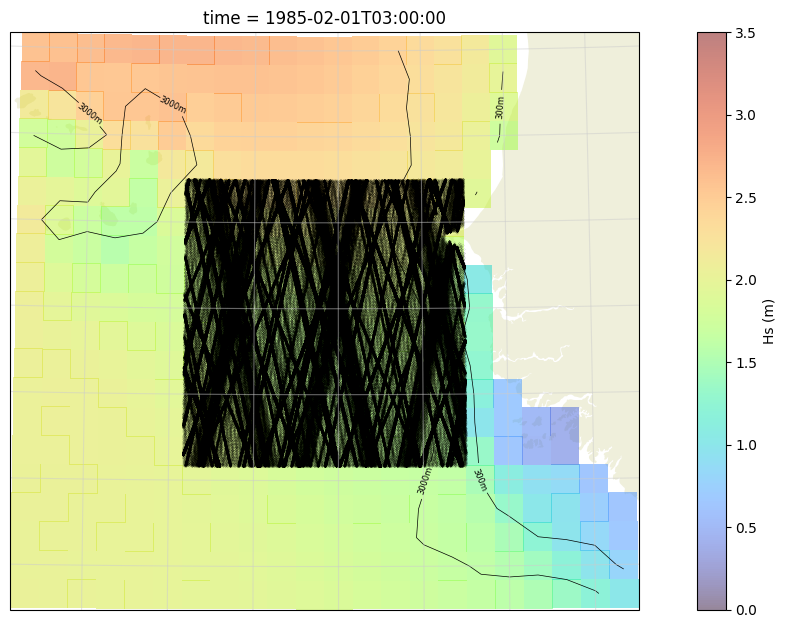

In [9]:
projection = ccrs.TransverseMercator(central_longitude=float(ds.longitude.mean()))

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))

# Show hindcast grid snapshot
ds.isel(time=1).hs.plot(ax=ax, cmap="turbo", vmin=0, vmax=3.5, alpha=0.5, cbar_kwargs=dict(label="Hs (m)"), transform=TRANSFORM)
c = ds.isel(time=1).dpt.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=TRANSFORM)
c.clabel(fmt="%0.0fm", fontsize=6)

# Show satellite passes
ax.plot(dfsat.longitude, dfsat.latitude, ".k", markersize=0.2, alpha=0.5, transform=TRANSFORM)


# Show the land mask
ax.add_feature(cfeature.LAND)

#ax.set_extent([x0, x1, y0, y1])
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

#### Colocate the colocations

Interpolate hindcast at the satellite times

In [10]:
colocs = interpolate_model_to_altimeter(dfsat, ds)

#### Plot all the colcation in a single scatter plot and calculate statistics

In [11]:
def get_color_mapping(df, cmap="tab20"):
    """Get the colors and legend handles to make a scatter with satellite labels."""
    df["label"] = df.platform.str.strip()
    cm = plt.get_cmap(cmap, df.label.unique().size)
    platform_to_color = {label: cm(i) for i, label in enumerate(df.label.unique())}
    colors = df["label"].map(platform_to_color)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=l) for l, c in platform_to_color.items()]
    return colors, legend_handles


def plot_satellite_scatter(df, x, y, ax, cmap="tab20"):
    """Plot scatter of satellite vs NDBC or hindcast colocations."""
    xlim = ylim = [0, 5]

    # Plot points
    colors, legend_handles = get_color_mapping(df, cmap)
    p = ax.scatter(df[x], df[y], s=5, c=colors, vmin=None, vmax=None, alpha=1.0)
    ax.legend(handles=legend_handles, title="Platform", fontsize=8)

    # Calculate and plot quantiles
    dfq = df[[x, y]].quantile(q=np.arange(0, 1.01, 0.01))
    ax.plot(dfq[x], dfq[y], "ok")

    # Equality line
    ax.plot(xlim, ylim, "--", color="0.5")

    # Show error statistics
    ax.annotate(errors(df, x, y), xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, color="0.0", bbox=dict(facecolor="0.9"))

    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Hs satellite (m)")
    yname = "NDBC" if "obs" in y else "hindcast"
    ax.set_ylabel(f"Hs {yname} (m)");

    return ax

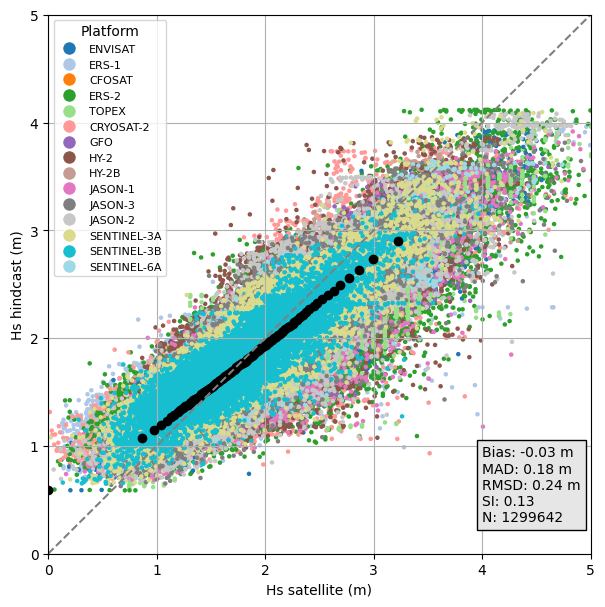

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))


# Satellite vs model
ax = plot_satellite_scatter(colocs, x="swh_ku_cal", y="model_hs", ax=axs)

### Calculate and plot stats spatially

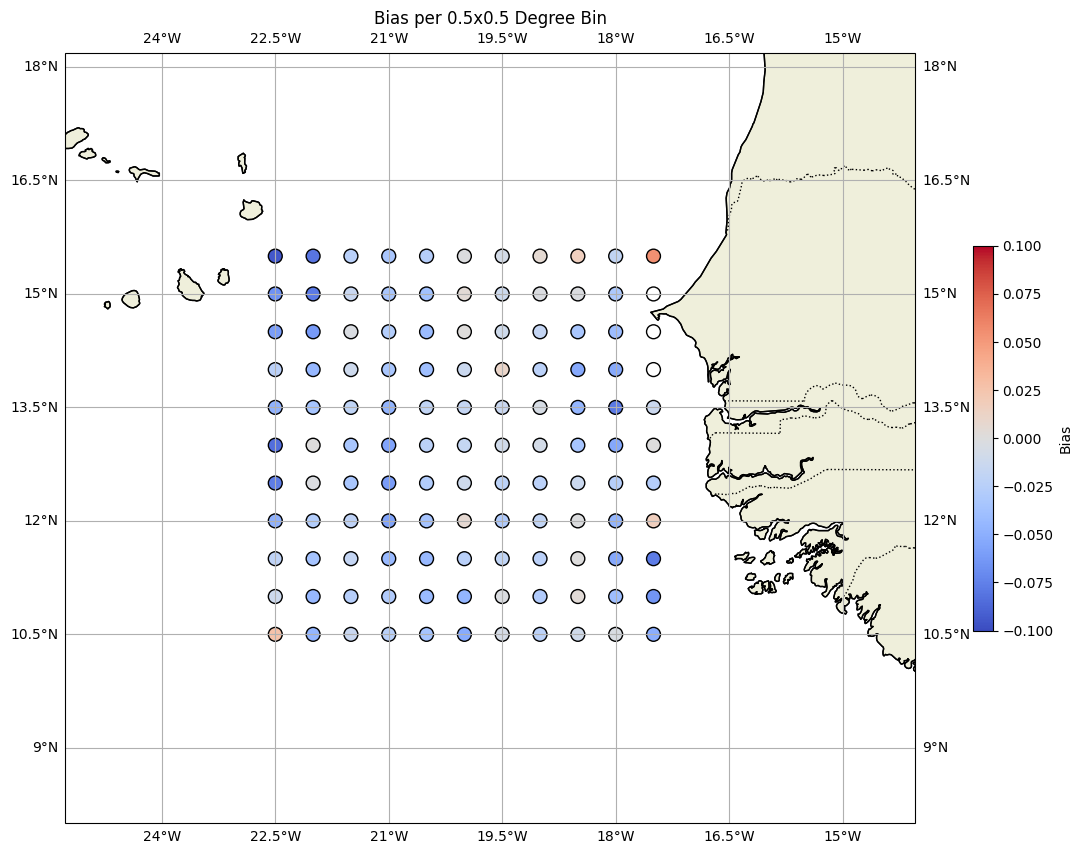

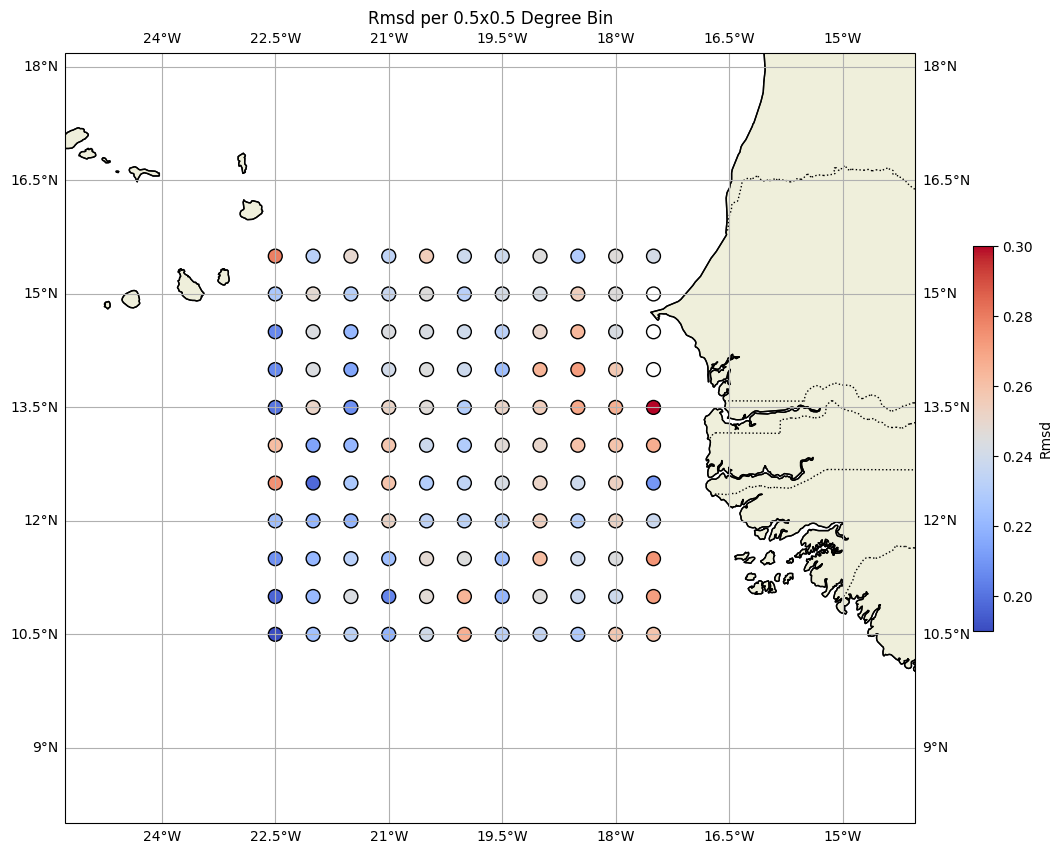

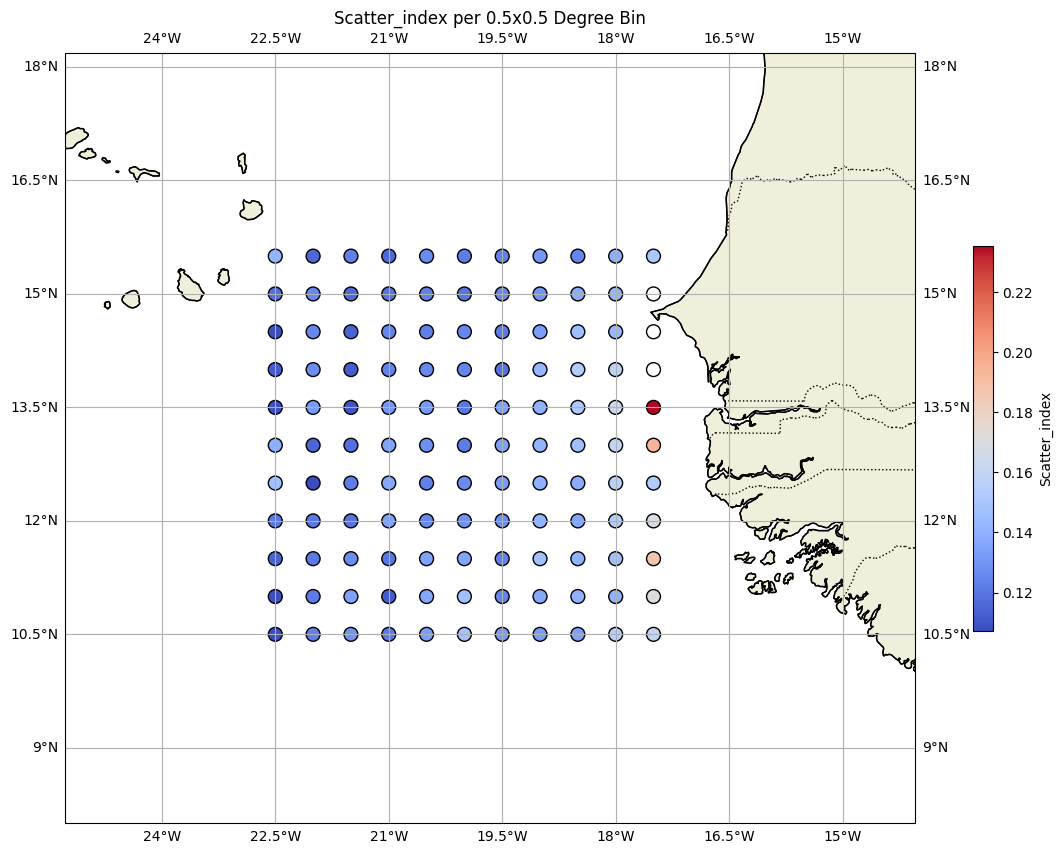

In [13]:
def calculate_statistics_per_bin(df):
    # Create bins for latitude and longitude
    df['lat_bin'] = (df['latitude'] // 0.5) * 0.5
    df['lon_bin'] = (df['longitude'] // 0.5) * 0.5
    
    # Define a function to calculate the statistics
    def calculate_stats(group):
        obs = group['swh_ku_cal']
        model = group['model_hs']
        bias = np.mean(model - obs)
        rmsd = np.sqrt(np.mean((model - obs) ** 2))
        scatter_index = rmsd / np.mean(obs) if np.mean(obs) != 0 else np.nan
        return pd.Series({'bias': bias, 'rmsd': rmsd, 'scatter_index': scatter_index})
    
    # Group by the latitude and longitude bins and calculate the statistics
    stats_df = df.groupby(['lat_bin', 'lon_bin']).apply(calculate_stats).reset_index()
    
    return stats_df



def plot_statistics_on_map(stats_df, stat='bias', **kwargs):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    
    
    # Plot the data
    scatter = ax.scatter(
        stats_df['lon_bin'], stats_df['lat_bin'],
        c=stats_df[stat], cmap='coolwarm', s=100, edgecolor='k',
        transform=ccrs.PlateCarree(), zorder=1, **kwargs
    )
    # Add map features
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
    cbar.set_label(f'{stat.capitalize()}')

    ax.set_extent([geom[0], geom[2], geom[1], geom[3]])

    # Set title
    ax.set_title(f'{stat.capitalize()} per 0.5x0.5 Degree Bin')
    
    plt.show()

stats_df = calculate_statistics_per_bin(colocs)
# Plot bias
plot_statistics_on_map(stats_df, stat='bias', vmin=-0.10, vmax=0.10)
# Plot RMSD
plot_statistics_on_map(stats_df, stat='rmsd')
# Plot scatter index
plot_statistics_on_map(stats_df, stat='scatter_index')




### Calculate and plot monthly statistics over the whole area

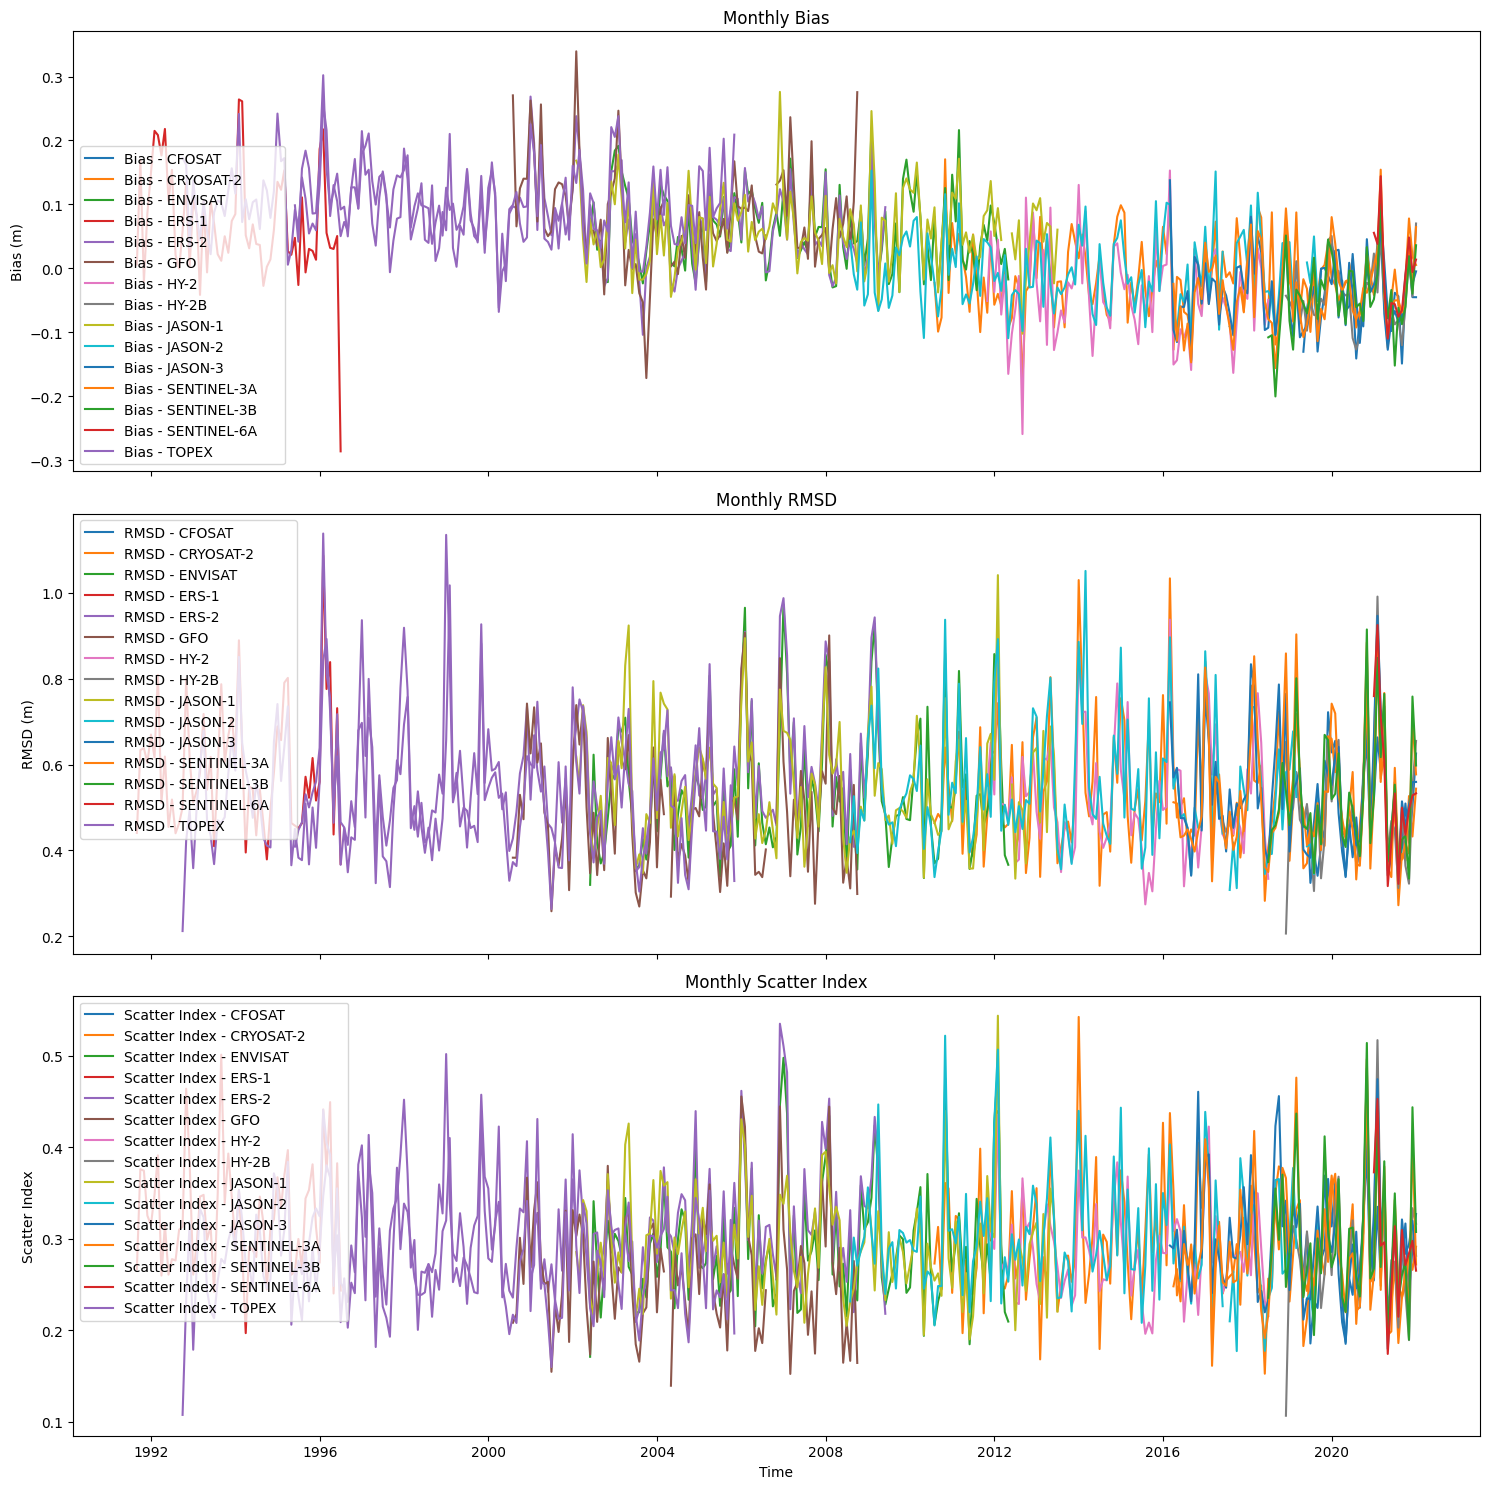

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_monthly_statistics(result_df):
    # Ensure the 'time' column is a datetime type
    # result_df['time'] = pd.to_datetime(result_df.index)
    
    # Set the 'time' column as the index
    result_df = result_df.set_index('time')
    
    # Group by platform and resample the data by month
    monthly_data = result_df.groupby('platform').resample('M').agg({
        'swh_ku_cal': ['mean', 'std'],
        'model_hs': ['mean', 'std']
    })
    # Flatten MultiIndex columns
    monthly_data.columns = ['_'.join(col).strip() for col in monthly_data.columns.values]
    
    # Calculate bias and rmsd for each platform and month
    monthly_data['bias'] = monthly_data['swh_ku_cal_mean'] - monthly_data['model_hs_mean']
    monthly_data['rmsd'] = np.sqrt((monthly_data['swh_ku_cal_mean'] - monthly_data['model_hs_mean'])**2 + 
                                   monthly_data['swh_ku_cal_std']**2 + 
                                   monthly_data['model_hs_std']**2)
    return monthly_data

def plot_monthly_statistics(monthly_data):
    platforms = monthly_data.index.get_level_values(0).unique()
    fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    
    # Plot for each platform
    for platform in platforms:
        platform_data = monthly_data.loc[platform]
        
        # Plot bias
        axs[0].plot(platform_data.index, platform_data['bias'], label=f'Bias - {platform}')
        
        # Plot RMSD
        axs[1].plot(platform_data.index, platform_data['rmsd'], label=f'RMSD - {platform}')
        
        # Plot scatter index (as RMSD/mean observed wave height)
        scatter_index = platform_data['rmsd'] / platform_data['swh_ku_cal_mean']
        axs[2].plot(platform_data.index, scatter_index, label=f'Scatter Index - {platform}')
    
    # Add labels and titles
    axs[0].set_ylabel('Bias (m)')
    axs[0].set_title('Monthly Bias')
    axs[0].legend()
    
    axs[1].set_ylabel('RMSD (m)')
    axs[1].set_title('Monthly RMSD')
    axs[1].legend()
    
    axs[2].set_ylabel('Scatter Index')
    axs[2].set_title('Monthly Scatter Index')
    axs[2].legend()
    
    # Set common x-axis label
    axs[2].set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()



monthly_data = calculate_monthly_statistics(colocs)
plot_monthly_statistics(monthly_data)
